# Neural Networks

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F10_neural_networks.ipynb)

<div class="alert alert-block alert-warning">
    <b>Prerequisites</b>
    <br>
    
- Matrix calculus
- Ordinary least squares
- Classification
    
</div>

<div class="alert alert-block alert-info">
    <b>Learning Outcomes</b>
    <br>

- Understand the neural network formalism.
- Program a gradient descent algorithm with backpropagation to optimize a neural network. 
- Train and test a neural network. 
    
</div>

## Introduction

### Objective

- Review the architecture of neural networks.
- Build a neural network from scratch in order to study each component. 

### Case study

- **Goal:** recognize hand-written digits from the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.
- **Dataset:**
    - 70000 images of hand-written digits (from 0 to 9) collected in an American administration.
    - Small and clean with well identified categories (hence its popularity in machine learning).
    - Why? We have not yet found an equivalent dataset in climate/energy science that is small enough to quickly build and test our programs.

Here is an example of a sequence of numbers from this dataset:

<img alt="weather" src="images/MnistExamples.png" width=600 style="float:center">

**Figure:** 28 x 28 pixels images of handwritten numbers from 0 to 9. Author: Suvanjanprasai. License: [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en).



In this figure:
- One has no issue recognizing each digit: for each image, we immediately attach a label to our visual impression.
- Yet, the task of writing a computer program that is able to identify each individual image seems complicated.
- Each digit can indeed be written in many different ways and there are no clear logical instructions on how to proceed to identify the digit pattern.

The following code cells read and plot the MNIST data.

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# MNIST image size
MNIST_IM_SIZE = 28

# MNIST directory
DIR_MNIST = Path('data', 'mnist')

# MNIST training set configuration
N_TRAIN = 60000
FILE_TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
FILE_TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'

# MNIST test set configuration
N_TEST = 10000
FILE_TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
FILE_TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

In [2]:
def load_mnist_images(filename, num_images, mnist_im_size=MNIST_IM_SIZE):
    '''
    return flatten images
    '''
    f = gzip.open(filename,'r')
    f.read(16)
    buf = f.read(num_images * mnist_im_size**2)
    images = np.frombuffer(buf, dtype=np.uint8) / 255.
    images = images.reshape(num_images, mnist_im_size**2)
    f.close()

    return images

def load_mnist_labels(filename, num_labels):

    f = gzip.open(filename, 'r')
    f.read(8)
    buf = f.read(num_labels)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    f.close()
  
    return labels

def plot_mnist_image(image, cmap=plt.cm.gray_r):
    n_side = int(np.sqrt(len(image)))
    plt.figure()
    plt.imshow(image.reshape((n_side, n_side)), cmap=cmap)

In [3]:
# Read training set
X_train = load_mnist_images(Path(DIR_MNIST, FILE_TRAIN_IMAGES), N_TRAIN)
y_train = load_mnist_labels(Path(DIR_MNIST, FILE_TRAIN_LABELS), N_TRAIN)

# Read test set
X_test  = load_mnist_images(Path(DIR_MNIST, FILE_TEST_IMAGES), N_TEST)
y_test  = load_mnist_labels(Path(DIR_MNIST, FILE_TEST_LABELS), N_TEST)

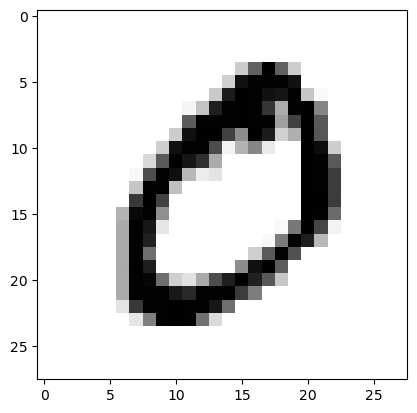

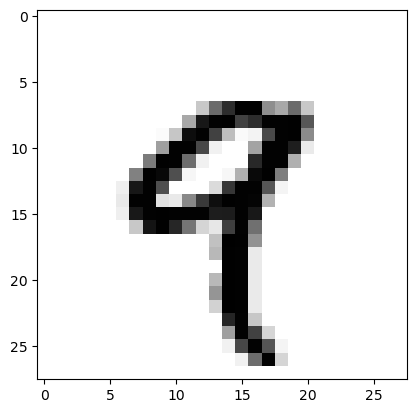

In [4]:
# Plot examples of 0 and 9
plot_mnist_image(X_train[1])
plot_mnist_image(X_train[4])

### Supervised-learning approach

- **Classification problem:** Learn the patterns from a training set made of couples of an image and a number between 0 and 9 ($K = 10$).
- **Discriminative model:** Directly predict the probability $P(C = k | \boldsymbol X = \boldsymbol x)$ to observe a $k$th digit given the image $\boldsymbol x$.

The function to estimate is thus,

\begin{equation}
\boldsymbol y = f(\boldsymbol x),
\end{equation}

where $\boldsymbol y$ is a $K$-dimensional vector such that its $k$th element corresponds to the probability $P(C = k | \boldsymbol X = \boldsymbol x)$ (see [Classification II: Discriminative models
](07_classification_discriminative.ipynb)).

In the example of handwritten digits:
- $\boldsymbol x$ is a multivariate vector that contains the grayscale value of each pixel of the image.
- Each image of this dataset is 28 pixels by 28 pixels and so each vector of the input space has dimension $p =784$.
- The convention that 0 is white and 1 is black is followed.
- Any value between 0 and 1 corresponds to some level of gray.

<div class="alert alert-block alert-warning">
    <b>Warning</b>
    
This dataset is interesting for teaching purposes but it may also convey the idea that neural networks are simple and always work.
    
Dealing with more serious machine learning problems, one soon realizes that datasets tend to be more complex.
</div>

## Building blocks of Neural Networks

### Neurons

In neural network terminology:
- $\boldsymbol x$ is the the input layer;
- each component of $\boldsymbol x$ is a *neuron*;
- the numerical value held by the neuron is a real number called the *activation*;
- a neuron is *active* (resp. *inactive*) when it holds a positive (resp. non-positive) value.

Here, the activation of the input layer corresponds to the grayscale value of the corresponding pixel on the image: white pixels have activation equal to zero and black pixels have activation equal to 1.

#### The MNIST input layer

<img alt="weather" src="images/mnist_52.png" width=300 style="float:left">

\begin{align}
 \boldsymbol{x} &=
 \begin{pmatrix}
    x_0 \\
    x_1 \\
    x_2 \\
    \vdots \\
    x_{p - 1} \\
  \end{pmatrix}
\end{align}



#### The MNIST output layer

The values of the neurons of the output layer $\boldsymbol y$ can be interpreted as the probabilities of each class given the input.

In the MNIST example, the $k$th class corresponds to the digit $k - 1$). For instance, if
$$
\boldsymbol y^\top = \left(0.01, 0.9, 0.2, 0.1, 0.05, 0.09, 0.05, 0.03, 0.25, 0.1\right)
$$
the most probable digit is $k = 1$ (the second class).

<div class="alert alert-block alert-warning">
    <b>Remark</b>
    
The output does not have to be between 0 and 1. In that case, one simply selects the neuron that is the most active.
</div>



#### The simplest neural network for the MNIST example

<img alt="weather" src="images/nnet_mnist.png" width=400 style="float:right">

The simplest neural network that one can build for this problem is represented in the following figure (mind the differences in notations with this course).

Each link represents a contribution of an input to an output.

Here, each contribution is linear because no activation function has been applied yet.

Thus, in this network, all outputs are linear combinations of all features.

### A two-layer linear network

In the simplest construction, the outputs are linear functions of the inputs, so that

\begin{equation}
\hat y_k = \sum_{j = 1}^{p} w_{kj} x_j + b_k,
\end{equation}

for some matrix $\boldsymbol W$ with elements $w_{kj}$, or *weights*, and some vector $\boldsymbol b$ with elements $b_k$, or *biases*, for $0 \le k \le K -1 $ and $1 \le j \le p$.


In matrix form,

\begin{equation}
\hat {\boldsymbol y} = \boldsymbol W \boldsymbol x + \boldsymbol b.
\end{equation}

This is a linear regression model with multiple outputs applied to classification.

If we use the Mean-Squared Error (MSE) as loss function, this is just an Ordinary Least Squares (OLS) problem.

<div class="alert alert-block alert-warning">
    <b>Remark</b>
    
More layers could be added to this two-layer linear model.

However, since a linear function of a linear function is itself linear, the resulting model would linearly link all outputs to all inputs and thus be equivalent to the two-layer linear model.
</div>

### From a linear model to a non-linear model

- Non-linear functions are now applied to the linear combination of the features.
- These functions are referred to as *activation function*, since their role is to turn on or off a neuron, and the value they return (the state of the neuron) as the *activation*.
- Their role is crucial since their non-linearity is what distinguishes a linear model that is able to represent linear relationships only from a neural network that can capture nonlinear interactions between features and combinations of features.

Let us introduce some possible activation functions (see [Table of activation functions on Wikipedia](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) for other examples).

#### Heaviside distribution

The Heaviside distribution (or step function, or binary step) is defined as

\begin{equation}
f(x)={\begin{cases}1,&x>0\\0,&x\leq 0\end{cases}}
\end{equation}

If we apply this function to the weighted sum, we then get a binary neuron: its activation state is either 0 or 1.

In neural network terminology, the association of the weighted sum and Heaviside activation function is called a *perceptron*.

---
**Perceptron**

A perceptron is a function that maps an input vector $\boldsymbol x$ to a single binary value depending on the value of the affine transformation of $\boldsymbol x$:

\begin{equation}
f(\boldsymbol x) =
\begin{cases}
    1 & {\text{if }}\ \boldsymbol w_k^\top \boldsymbol x + b_k > 0\\
    0 & {\text{otherwise}}.
\end{cases}
\end{equation}

---

In this case, the activation state of a neuron can only be 0 or 1.

For multiple classes, we can set the output of the perceptron to the class label for the largest $\boldsymbol w_k \boldsymbol x + b_k$.

We then have a single output $\hat{y}$ taking as many values as class labels.

We are left with an optimization problem where we need to adjust these weights and biases to minimize the error in the image recognition.

> ***Question***
> - For this simple network, do you have an intuition for how the weights should combine to recognize a "0"? a "9"? (again think of the perceptron as a weighted sum)

Let's check it with scikit-learn. For now we will let scikit-learn handle all the heavy lifting (i.e. finding the best set of weights and biases)

In [9]:
from sklearn.linear_model import Perceptron

clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)

Train score (% of correct classification): 89 %


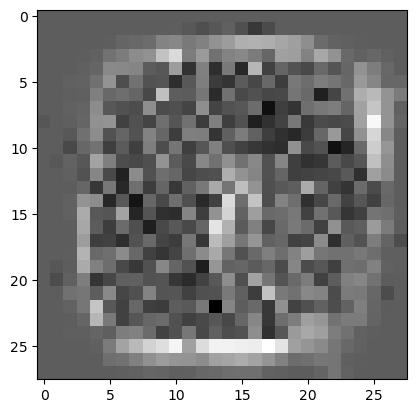

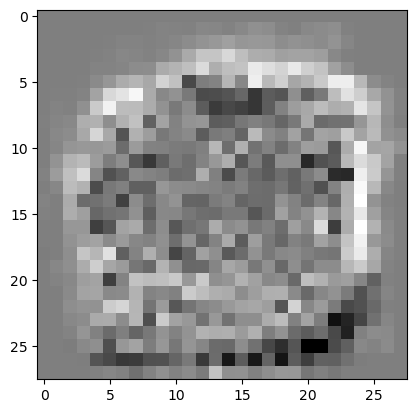

In [6]:
print('Train score (% of correct classification): {:.0f} %'.format(
    train_score * 100))
plot_mnist_image(clf.coef_[0])
plot_mnist_image(clf.coef_[9])  

In the figure above, we plotted the weights for the class "0" and the weights for the class "9". You can compare these pattern with the actual "0" and "9" that we plotted above.

**Interpretation:**

- It seems that the weights are trying to pick up the edges of the digit pattern.
- However, the signal seems noisy.
- We are actually moving away from linear methods (maximum interpretability), trading interpretability against performance.

**Perceptrons limitations:**

- Perceptrons are highly nonlinear functions: when the weighted sum is close the threshold, a small modification of the input parameter will introduce a change of category.
- Perceptrons are not continuous functions and so they are not differentiable (optimization perspective).

In order to overcome these limitations, let us introduce two other popular activation functions: the sigmoid and the rectifier (ReLU for Rectified Linear Unit).

#### Sigmoid activation function

The sigmoid function is a good alternative to the Heaviside because the function and its derivative are continuous. (cf. classification)


> ***Question***
>
> - Can you recall the main properties of the sigmoid function? What is the role of the weights and biases?

In [15]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

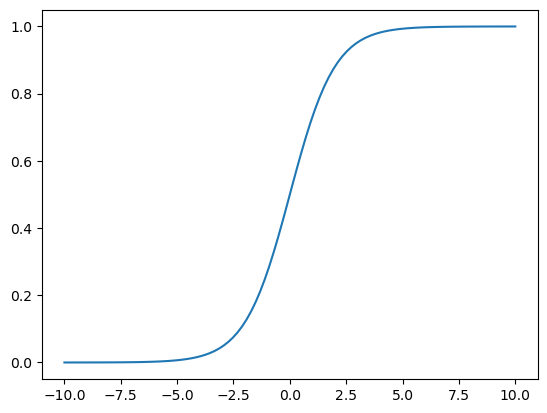

In [8]:
x = np.linspace(-10, 10, 100)
_ = plt.plot(x, sigmoid(x))

#### ReLU activation function

The ReLU activation function is defined as

\begin{equation}
f(x)=\max(0,x)
\end{equation}

This function will "activate" a neuron only if the input value is positive. Note that with this activation function, the activation level is not restricted to be between 0 an 1. Advantages of ReLU are that :
- they are cheap to compute (later on, we are going to use millions of these units so we need to take that into account) ;
- although its derivative is not continuous, is has nice properties for optimization purposes (the gradient does not vanish for large values of x, more on that later).

In [16]:
def relu(x):                                         
    return np.maximum(0, x)

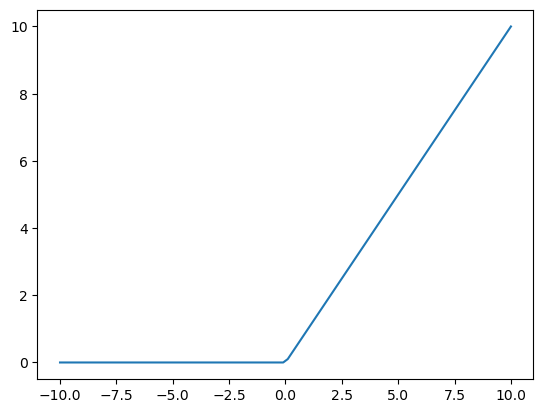

In [10]:
_ = plt.plot(x, relu(x))

Before to proceed, let us absorb the bias into the weight matrix to simplify the notation. To do so, we need to append a "1" to the $\boldsymbol x$ vector.

The affine transformation of the input vector is then given by the weighted sum:

\begin{equation}
\boldsymbol z = \boldsymbol W \boldsymbol x,
\end{equation}

where the last column of $\boldsymbol W$ is equal to $\boldsymbol b$, and the dimension of $\boldsymbol x$ is now $p + 1$.

### Cost function

In order to asses the performance of our network, we introduce the cost function that we want to minimize:

$$
C := \frac{1}{N} \sum_{i = 1}^N \| \boldsymbol y_i - \boldsymbol {\hat y}_i \|^2\, ,
$$

where $\boldsymbol y_i$ is the target of the $i$th sample and $\boldsymbol {\hat y}_i$ is the network output for that sample. The sum spans the entire training set of size $N$.

For an activation function $\sigma$, the cost function for an individual input writes

\begin{equation}
C_i := \| \boldsymbol y_i - \sigma (\boldsymbol W \boldsymbol x_i) \|^2\, .
\end{equation}


### Iterative algorithm: Gradient descent

To solve this minimization problem, we follow a standard iterative algorithm known as the gradient descent.

To illustrate it, let us first consider the two-class problem with a single sample:

\begin{equation}
C := (y - \sigma (\boldsymbol w^\top \boldsymbol x) )^2\, ,
\end{equation}

where $y$ is a scalar.

We want to find the set of weights and biases that minimize the cost function $C$. The cost function is minimum when 

\begin{equation}
\frac{d C}{d \boldsymbol w} = 0.
\end{equation}


> ***Question***
> 
> - Compute $dC/d \boldsymbol w$.

This nonlinear equation has no closed form solution so we will instead use an iterative algorithm.

We start from a first guess for the weights $\boldsymbol w^{(0)}$. For this value of the weights, we compute the value of the cost function $C$. We then add increments:

\begin{equation}
\boldsymbol w^{(1)} = \boldsymbol w^{(0)} + \delta \boldsymbol w^{(0)}
\end{equation}

The cost function will vary by an amount 

\begin{align}
\Delta C &= C\left(\boldsymbol w^{(1)}\right) - C\left(\boldsymbol w^{(0)}\right)\\
& = C\left(\boldsymbol w^{(0)} + \delta \boldsymbol w^{(0)}\right) - C\left(\boldsymbol w^{(0)}\right)\\
 & \simeq \left.\frac{d C}{d \boldsymbol w}\right|_{\boldsymbol w^{(0)}} \delta \boldsymbol w^{(0)}
\end{align}

> ***Question***
>
>- Show that if we choose 
\begin{equation}
\delta \boldsymbol w = - \lambda  \left[\frac{d C}{d \boldsymbol w}\right]^\top
\end{equation}
> then at each iteration, we have $\Delta C < 0$ when $\lambda$ is a positive number.


The parameter $\lambda$ is called the *learning rate*.

In the limit where linearity holds we can compute the little increments in the weights and biases that ensure that the cost function will decrease.

This method is called the *gradient descent*.

### Illustration of the gradient descent

We illustrate the gradient descent technique in the next figure for the case where $\boldsymbol w$ is dimension 2. The cost function $C$ is plotted with contours: it is minimum in the yellow area. The initial guess $\boldsymbol w^{(0)}$ is plotted with the red dot. The value of $\boldsymbol w$ for which $dC/d\boldsymbol w = 0$ is plotted with a red cross.


<img alt="weather" src="images/gradient_descent.png" width=400 style="float:center">


> ***Question***
>
> - What is the problem if $\lambda$ is too small? too big?
> - What happens if the cost function is a complicated function of $\mathbf w$ with many local minima?

In practice, the gradient descent method works well but is slow to converge.

There are other methods that have better convergence properties for this iterative process: [Newton-Raphson](https://en.wikipedia.org/wiki/Newton%27s_method), [Conjugate gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method), etc (see turorial)

### Hidden layers

In the perceptron model, the complexity of the relationship between the input and the output is limited. 

To overcome this limitation, one way is to add one or more *hidden layers* of neurons between the input and output layers.

The motivation to add these layers is to break down the problem into multiple small task, e.g. "pick and edge" and "find a strait line" in the case of the digit recognition.

<img alt="weather" src="images/hidden_layer.png" width=400 style="float:center">

The figure above is an illustration of the simplest possible architecture of a neural network: it comprises an input layer of $p$ neurons, one hidden layer, and one output layer.

For historical reasons, neural networks are sometimes called *multi-layer perceptron (MLP)* even if the activation functions in the hidden layers do not constitute a perceptron.

## Universal approximation theorem

Why could adding more layers help? 

The universal approximation theorem  states that a feedforward network with at least one hidden layer can approximate any continuous function with an (training) error that can be made as small as we want by adding neurons in the hidden layer.

Of course, the function $\boldsymbol x \to \boldsymbol y = f(\boldsymbol x)$ should exist for this theorem to be applied.

Hence, neural networks are "universal" tools (can be used every time we believe there exists a mapping: digit recognition, classification, uncover physical laws...).

One caveat however is that, if we are guaranteed the existence of a network, we have no guidance on how to find such network. We need to build a strategy to find the weights and biases to find that optimal solution.

Plus, minimizing the training error could lead to overfitting ; it is the expected prediction error that should be minimized.

## Training a neural network: backpropagation

Let us consider the case where we have more than one hidden layer.

We write with a subscript $\boldsymbol a^l$ the activation in the $l^{th}$ layer. So we have,

\begin{equation}
\boldsymbol a^l = \sigma \left( \boldsymbol W^l \boldsymbol a^{l-1} \right)
\end{equation}

with $\boldsymbol W^l$ the matrix of weights (including the bias) to compute the activation in layer $l$ and for some activation function $\sigma$.

The activation in the first layer is fixed to the input, $\boldsymbol x = \boldsymbol a^0$, while the activation  in the last layer gives the output, $\boldsymbol y = \boldsymbol a^L$, resulting in $L + 1$ layers.

We note,

\begin{equation}
\boldsymbol z^l := \boldsymbol W^l \boldsymbol a^{l-1},
\end{equation}

the weighted sum in layer $l$.

> ***Question***
>
> - If there are $p$ neurons in layer $l-1$ and $q$ neurons in layer $l$, what is the dimension of each of the terms in the equation above? (Hint: don't forget about the bias.)

The cost function is

\begin{equation}
C = \frac{1}{N}\sum_{i = 1}^N \| \boldsymbol y_i - \boldsymbol a^L_i \|^2\, .
\end{equation}

We want to compute the derivative of this cost function with respect to **all** weights and biases in the network in order to use the gradient descent algorithm:

\begin{equation}
\frac{\partial C}{\partial \boldsymbol W^l} \, ,
\end{equation}
for all $l$.

Observe that the derivatives in one layer is related to the derivatives in the previous layers by the chain rule:

\begin{equation}
\frac{\partial C}{\partial \boldsymbol W^l} = \frac{\partial C}{\partial \boldsymbol z^l} \frac{\partial \boldsymbol z^l}{\partial \boldsymbol W^l}.
\end{equation}

Let us introduce the notation

\begin{equation}
\boldsymbol \delta^l = \frac{\partial C}{\partial \boldsymbol z^l},
\end{equation}

which is a row vector according to our numerator layout convention.

Let's first derive $\mathbf \delta^L$ in the last layer. For a single point,

\begin{equation}
C = (\boldsymbol y - \sigma(\boldsymbol z^L))^\top ( \boldsymbol y - \sigma (\boldsymbol z^L))\, ,
\end{equation}

so,

\begin{equation}
\boldsymbol \delta^L = -2( \boldsymbol y - \sigma(\boldsymbol z^L))^\top \Sigma' (\boldsymbol z^L))\, ,
\end{equation}

where $\Sigma'$ is a matrix with diagonal entries which are $\sigma'(\boldsymbol z^l)$.

The derivative of a vector by a matrix is given by

\begin{equation}
\frac{\partial \boldsymbol z^l}{\partial \boldsymbol W^l} = \frac{\partial }{\partial \boldsymbol W^l}  \boldsymbol W^l \boldsymbol a^{l-1},
\end{equation}

which is a tensor of order 3 with a lot of zeros in it (sparsity).

The above equation simplifies in

\begin{equation}
\frac{\partial C}{\partial \boldsymbol W^l} = \boldsymbol a^{l-1} \delta^l.
\end{equation}

> ***Question***
>
> - What is the physical interpretation of this derivative?
> - *(Optional)* Verify that $\frac{\partial C}{\partial \boldsymbol W^l}$ is the same dimension as ${\boldsymbol W^l}^\top$

In addition, the chain rule gives us the following recurrence relation,

\begin{align}
\boldsymbol \delta^l &= \frac{\partial C}{\partial \boldsymbol z^{l+1}} \frac{\partial \boldsymbol z^{l+1}}{\partial \mathbf z^{l}}\\
&= \boldsymbol \delta^{l+1} \frac{\partial \boldsymbol z^{l+1}}{\partial \boldsymbol z^{l}}.
\end{align}

Moreover we have

\begin{equation}
\boldsymbol z^{l+1} = \boldsymbol W^{l+1} \boldsymbol a^l = \boldsymbol W^{l+1} \sigma(\boldsymbol z^l)
\end{equation}

so 

\begin{equation}
\frac{\partial \boldsymbol z^{l+1}}{\partial \boldsymbol z^{l}} = \boldsymbol W^{l+1} \Sigma'(\boldsymbol z^l).
\end{equation}

So we have

\begin{equation}
\boldsymbol \delta^l = \boldsymbol \delta^{l+1} \boldsymbol W^{l+1} \Sigma'(\boldsymbol z^l)
\end{equation}

> ***Question***
> 
> - Suppose that there are $p$ neurons in layer $l$ and $q$ neurons in layer $l+1$. What is the dimension of all the terms in the equation above?
> - Since $\Sigma'$ is a diagonal matrix, how are you going to compute the product of these 3 elements in a computer program?

<div class="alert alert-block alert-info">
    <b>Main equations</b>

- \begin{equation}
\frac{\partial C}{\partial \boldsymbol W^l} = \boldsymbol a^{l-1} \delta^l
\end{equation}
    
- \begin{equation}
\boldsymbol \delta^l = \boldsymbol \delta^{l+1} \boldsymbol W^{l+1} \Sigma'(\boldsymbol z^l)
\end{equation}
    
    
- \begin{equation}
\boldsymbol \delta^L = -2( \boldsymbol y - \sigma(\boldsymbol z^L))^\top \Sigma' (\boldsymbol z^L))\, ,
\end{equation}
</div>

Let us implement these formula in the [Tutorial: Universal approximation theorem](10_tutorial_neural_networks.ipynb) and see if we can make sense of it.

## References

- [Chap. 6 in Goodfellow, I., Bengio, Y., Courville, A., 2016. *Deep Learning*. MIT Press, Cambridge](https://www.deeplearningbook.org/contents/mlp.html).


***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>

#  